In [0]:
import tensorflow as tf
import numpy as np
import cv2,os,glob

In [0]:
def _bytes_feature(value):
    if isinstance(value, type(tf.constant(0))):
        value = value.numpy() # BytesList won't unpack a string from an EagerTensor.
    return tf.train.Feature(bytes_list=tf.train.BytesList(value=[value]))

def _float_feature(value):
    return tf.train.Feature(float_list=tf.train.FloatList(value=value))

def _int64_feature(value):
    return tf.train.Feature(int64_list=tf.train.Int64List(value=value))

In [0]:
def image_example(image_string,label):
    feature = {
      'image_raw': _bytes_feature(image_string),
        'label': _float_feature(label),
    }
    return tf.train.Example(features=tf.train.Features(feature=feature))  

In [0]:
class_list = ['Positive','Negative']

In [0]:
train_records = glob.glob('/content/drive/My Drive/BinaryCOVID-19/TFRecordTrain/*.tfrecord')
val_records = glob.glob('/content/drive/My Drive/BinaryCOVID-19/TFRecordTest/*.tfrecord')

train_dataset = tf.data.TFRecordDataset(train_records,num_parallel_reads=3)
val_dataset = tf.data.TFRecordDataset(glob.glob('/content/drive/My Drive/BinaryCOVID-19/TFRecordTest/*.tfrecord'),num_parallel_reads=3)

image_feature_description = {
    'image_raw': tf.io.FixedLenFeature([], tf.string),
    'label': tf.io.FixedLenFeature([2],dtype=tf.float32)
}

def _parse_image_function(example_proto):
  features = tf.io.parse_single_example(example_proto, image_feature_description)
  image_raw = tf.image.decode_jpeg(features['image_raw'],channels=1)
  image_raw = tf.cast(image_raw , tf.float32) * (1. / 255)
  image_raw = tf.image.resize(image_raw,(300,400))

  label = features['label']
  # label = [tf.argmax(label)]

  return image_raw,label

train_dataset = train_dataset.map(_parse_image_function)
val_dataset = val_dataset.map(_parse_image_function)

In [0]:
c0,c1 = 0,0
for i,j in train_dataset:
  if (j.numpy()==[1,0]).all():
    c0+=1
  elif (j.numpy()==[0,1]).all():
    c1+=1
c0,c1   

In [0]:
c2,c3 = 0,0
for i,j in val_dataset:
  if (j.numpy()==[1,0]).all():
    c2+=1
  elif (j.numpy()==[0,1]).all():
    c3+=1
c2,c3      

In [0]:
TRAIN_BATCH = 8
VAL_BATCH = 16

train_dataset = train_dataset.repeat().shuffle(2000).batch(TRAIN_BATCH).prefetch(8)
val_dataset = val_dataset.repeat().shuffle(150).batch(VAL_BATCH)
train_dataset,val_dataset

In [0]:
samples = {0:(3904+195)/(2*195),1:(3904+195)/(2*3904)}
print(samples)
total_train_samples = c0+c1
total_test_samples = c2+c3

In [0]:
from tensorflow.keras.layers import Conv2D,GlobalMaxPooling2D,Dense,Dropout,BatchNormalization,MaxPool2D,DepthwiseConv2D,Flatten
def create_model(shape=(300,400,1)):

  first_layer = 32
  second_layer = 8
  third_layer = 4

  input_layer = tf.keras.layers.Input(shape=shape)

  conv1 = Conv2D(64,(3,3),activation='relu')(input_layer)
  mp1 = MaxPool2D()(conv1)
  depth_conv1 = DepthwiseConv2D((5,5))(mp1)
  mp2  = MaxPool2D()(depth_conv1)

  conv2 = Conv2D(64,(3,3),activation='relu')(input_layer)
  mp3 = MaxPool2D()(conv2)
  depth_conv2 = DepthwiseConv2D((5,5))(mp3)
  mp4  = MaxPool2D()(depth_conv2)

  merge = tf.keras.layers.concatenate([mp2,mp4])
  bn = BatchNormalization()(merge)

  conv3 = Conv2D(32,(2,2),activation='relu')(bn)
  mp5 = MaxPool2D()(conv3)
  depth_conv3 = DepthwiseConv2D((2,2))(mp5)
  mp6  = MaxPool2D()(depth_conv3)

  conv4 = Conv2D(32,(2,2),activation='relu')(bn)
  mp7 = MaxPool2D()(conv4)
  depth_conv4 = DepthwiseConv2D((2,2))(mp7)
  mp8  = MaxPool2D()(depth_conv4)
  
  merge1 = tf.keras.layers.concatenate([mp6,mp8])
  bn1 = BatchNormalization()(merge1)

  conv5 = Conv2D(16,(3,3),activation='relu')(bn1)
  mp9 = MaxPool2D()(conv5)
  depth_conv5 = DepthwiseConv2D((3,3))(mp9)
  mp10  = MaxPool2D()(depth_conv5)

  conv6 = Conv2D(16,(3,3),activation='relu')(bn1)
  mp11 = MaxPool2D()(conv6)
  depth_conv6 = DepthwiseConv2D((3,3))(mp11)
  mp12  = MaxPool2D()(depth_conv6)

  merge2 = tf.keras.layers.concatenate([mp10,mp12])
  bn2 = BatchNormalization()(merge2)

  flatten = Flatten()(bn2)

  drop1 = Dropout(0.5)(flatten)
  dense1 = Dense(32,activation='relu')(drop1)
  drop2 = Dropout(0.5)(dense1)
  dense2 = Dense(16,activation='relu')(drop1)
  final = Dense(2,activation='softmax')(dense2)

  model = tf.keras.models.Model(inputs=[input_layer],outputs=[final])

  return model

Model: "model_2"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_5 (InputLayer)            [(None, 300, 400, 1) 0                                            
__________________________________________________________________________________________________
conv2d_20 (Conv2D)              (None, 298, 398, 64) 640         input_5[0][0]                    
__________________________________________________________________________________________________
conv2d_21 (Conv2D)              (None, 298, 398, 64) 640         input_5[0][0]                    
__________________________________________________________________________________________________
max_pooling2d_40 (MaxPooling2D) (None, 149, 199, 64) 0           conv2d_20[0][0]                  
____________________________________________________________________________________________

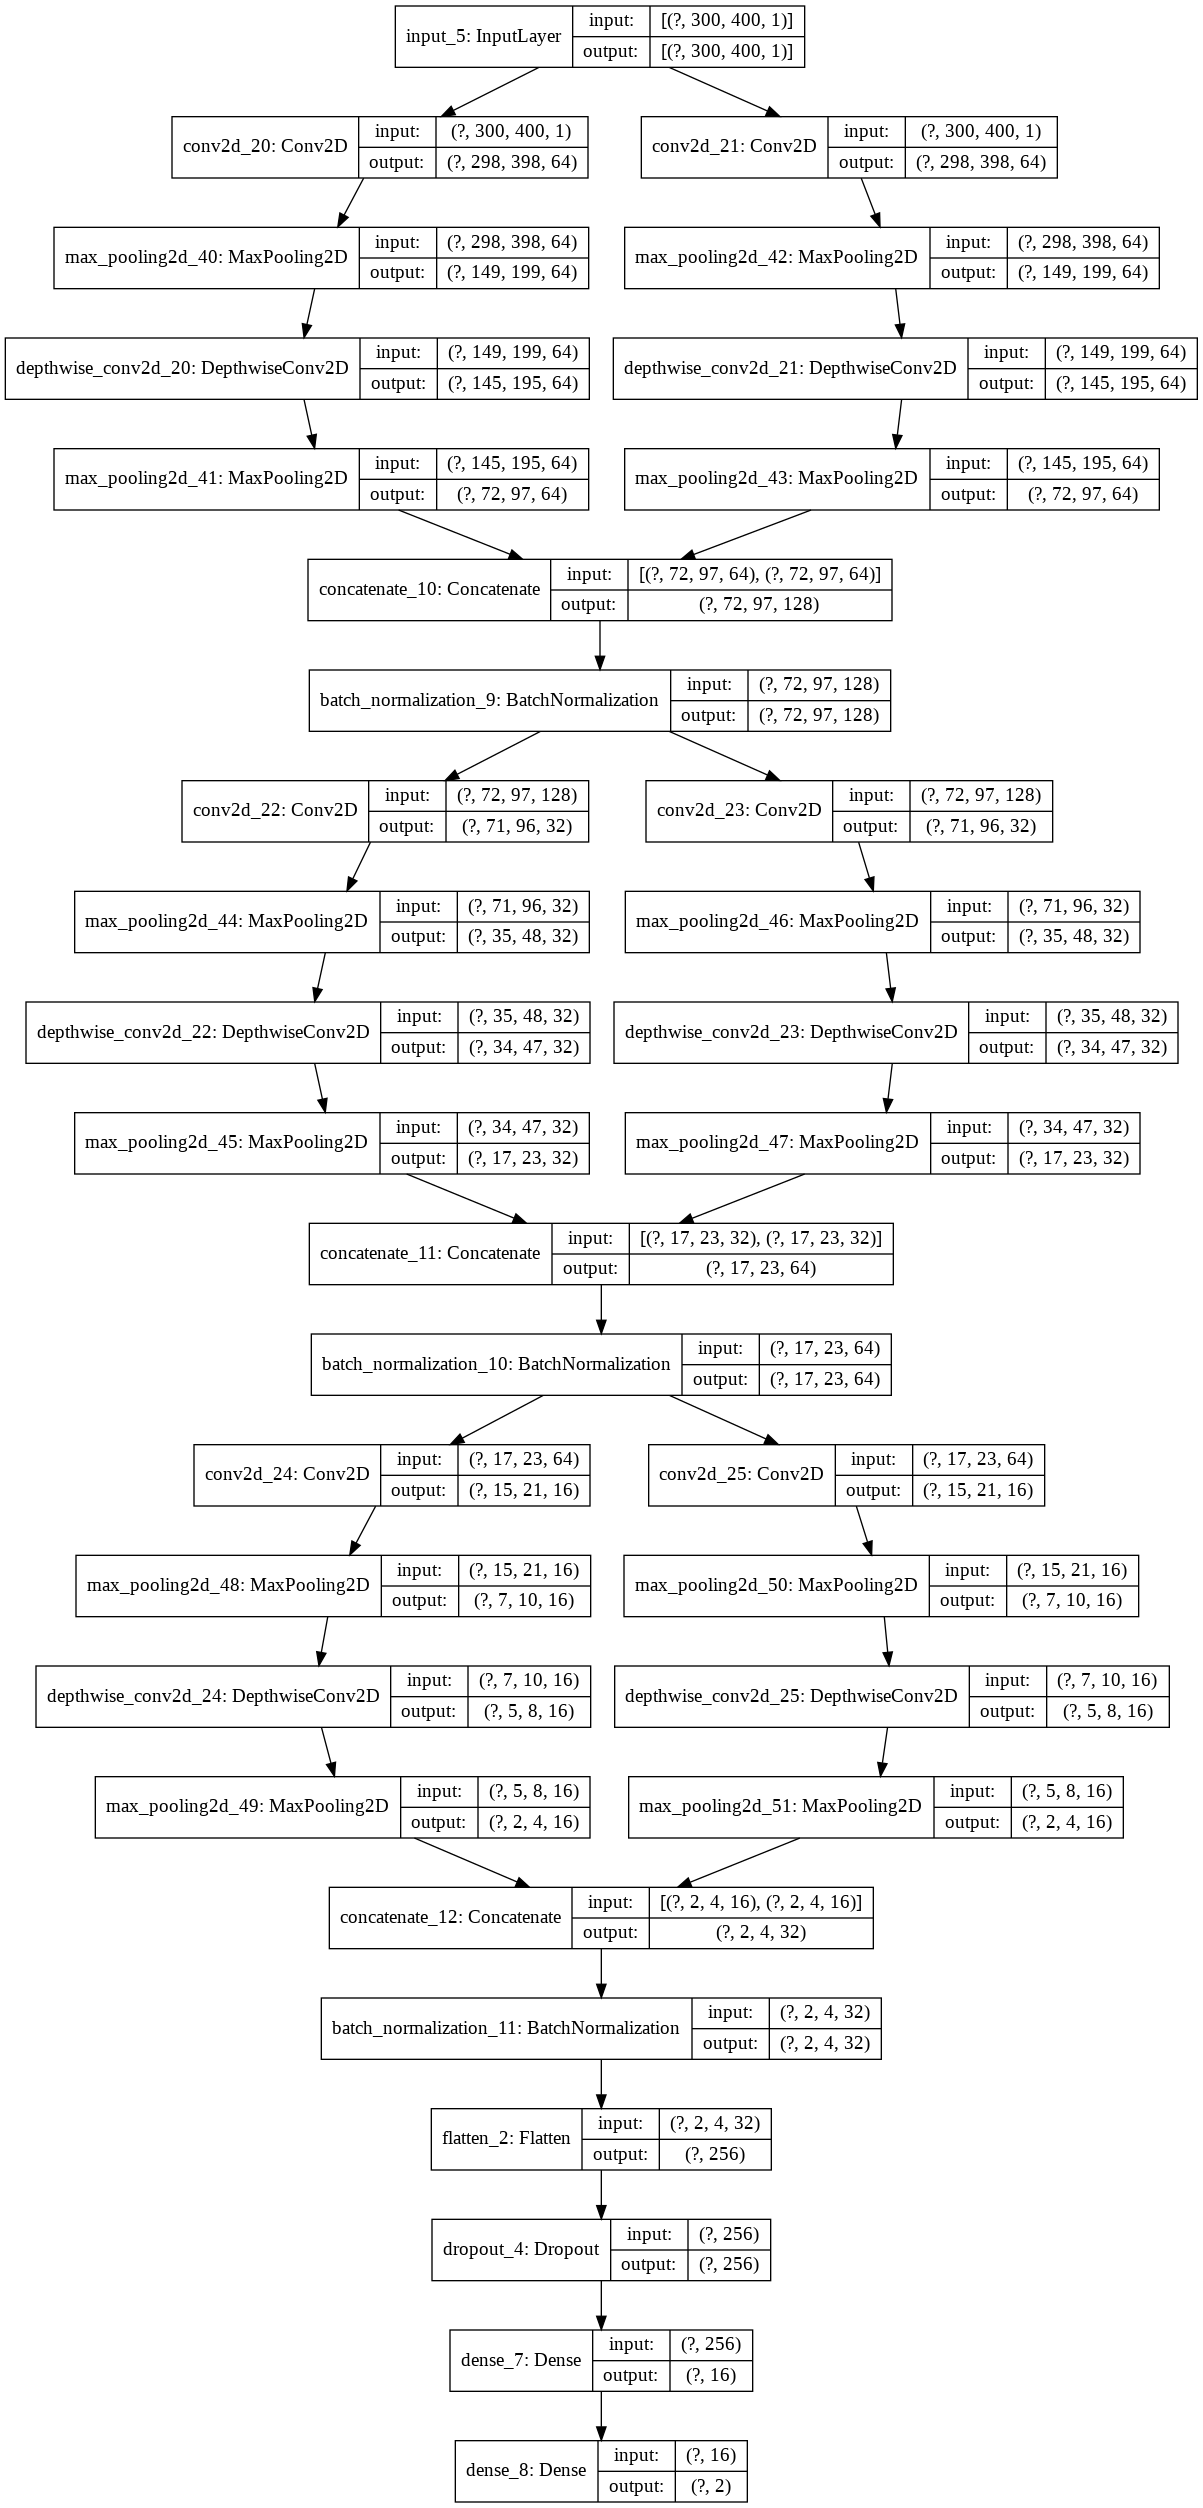

In [21]:
from tensorflow.keras.utils import plot_model
model = create_model()
model.summary()
plot_model(model,'Model.png',show_shapes=True)

In [0]:
optimizer = tf.keras.optimizers.Adam()
model.compile(loss='categorical_crossentropy',optimizer=optimizer,weighted_metrics=['accuracy',tf.keras.metrics.Precision(),tf.keras.metrics.Recall(),tf.keras.metrics.AUC()])

In [0]:
checkpoint = tf.keras.callbacks.ModelCheckpoint('Checkpoint2.h5',save_best_only=True,verbose=1)
early_stopping = tf.keras.callbacks.EarlyStopping(patience=6,verbose=1)

In [25]:
model = tf.keras.models.load_model('/content/drive/My Drive/BinaryCOVID-19/BinaryCOVID-19Classifier.h5')

In [0]:
model.fit(train_dataset,validation_data=val_dataset,epochs=10,class_weight=samples,steps_per_epoch=total_train_samples//TRAIN_BATCH,validation_steps=total_test_samples//VAL_BATCH,callbacks=[early_stopping])

In [0]:
model = tf.keras.models.load_model('/content/drive/My Drive/BinaryCOVID-19/BestModel.h5')

In [0]:
image,files = [],[]
acc=0
test_files = glob.glob('/content/drive/My Drive/COVID-19-Xrays/test/*')
print(len(test_files))
for i in test_files:
  img = open(i,'rb').read()
  img = tf.io.decode_jpeg(img,channels=1)
  img = tf.cast(img , tf.float32) * (1. / 255)
  img = tf.image.resize(img,(300,400))
  preds = model.predict(np.expand_dims(img,axis=0))
  image.append(class_list[np.argmax(preds)])
  name = os.path.basename(i).split('.')[0]
  files.append(name)
for i,j in zip(files,image):
  print(i,j)